# Hamiltonian simulation with Gray code encoding - statevector simulator

In [37]:
import numpy as np
np.warnings.filterwarnings('ignore')

import pickle

from scipy.linalg import expm
# import scipy
from pprint import pprint
from tqdm import tqdm

from scipy.linalg import lstsq
from scipy.linalg import eig
import scipy as sp

# Everything we need from Qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info import Pauli

from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom

import qutip as qt
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set()

import itertools

import sys
sys.path.append("../src/")
from hamiltonian import *
from utils import *
from qiskit_circuits import *
from qite import *

## Playing with Pauli and WeightedPauli operators

In [141]:
## H is always in qiskit order (right to left)
## String form is also in that order 
## State vector results in order [00,01,10,11]

n_qubits=3
H = DenseEncodingHamiltonian(N_states=2**n_qubits,qiskit_order=False)
print(H.pauli_coeffs)
print("")
eigE,vecE=eig(H.matrix)
print(eigE.real)

{'IIX': -14.835491855223372, 'ZIX': 7.021540219181213, 'IZX': 0.012233677372333496, 'ZZX': 3.5151109087992642, 'IXI': -7.420932728910914, 'ZXI': 3.5078137682862827, 'IXZ': 7.420932728910914, 'ZXZ': -3.5078137682862827, 'XII': -3.7123106012293743, 'XZI': 3.7123106012293743, 'XIZ': -3.7123106012293743, 'XZZ': 3.7123106012293743, 'III': 29.03917736125, 'ZII': -14.710822638749999, 'IZI': -0.710822638749999, 'ZZI': -7.71082263875, 'IIZ': -0.7108226387499998, 'ZIZ': -0.7108226387499998, 'IZZ': -0.7108226387499998, 'ZZZ': -4.21082263875}

[-2.21503787  2.52159867  8.32143272 16.32766303 26.59557563 39.95924445
 57.74792829 83.05501397]


In [3]:
## vector of WeightedPauliOperators representing vector Sigma -- a list of all pauli terms with odd number of Y gates
sigmas=get_sigma_pauli_terms(n_qubits)

## b=i[H,sigma]
b_pauli_terms=b_terms(H,sigmas)

##S_{ij}=2sigma_i.sigma_j
S_pauli_terms=S_terms(sigmas)

## Set of all pauli terms needed to compute H, b, and S
pauli_set=get_intersection_pauli_terms(H,b_pauli_terms,S_pauli_terms)

## Organize pauli set into commuting sets of pauli operators 
commuting_sets=get_commuting_sets(sorted(pauli_set))
print("key, [paulis in set]")
for p in commuting_sets:
    print(p, commuting_sets[p])

key, [paulis in set]
XX ['II', 'IX', 'XI', 'XX']
XY ['IY', 'XY']
XZ ['IZ', 'XZ']
YX ['YI', 'YX']
YY ['YY']
YZ ['YZ']
ZX ['ZI', 'ZX']
ZY ['ZY']
ZZ ['ZZ']


In [138]:
#####################################       
# Prepare and run the evolution circuit
#####################################       
num_iterations=50
delta_time=0.01

initialization="zeros"
H = DenseEncodingHamiltonian(N_states=2**n_qubits,qiskit_order=False)

backend = 'statevector_simulator'
merge_stride=9
sv_energies,Ccoefs_sv=run_qite_experiment(H,num_iterations,delta_time,backend,initialization,A_threshold=1e-10,cstep=merge_stride)

# threshold=1e-2
# backend = 'qasm_simulator'
# qasm_energies,Ccoefs_qasm=run_qite_experiment(H,num_iterations,delta_time,backend,initialization,A_threshold=threshold,cstep=None)



100%|██████████| 50/50 [00:12<00:00,  4.06it/s]


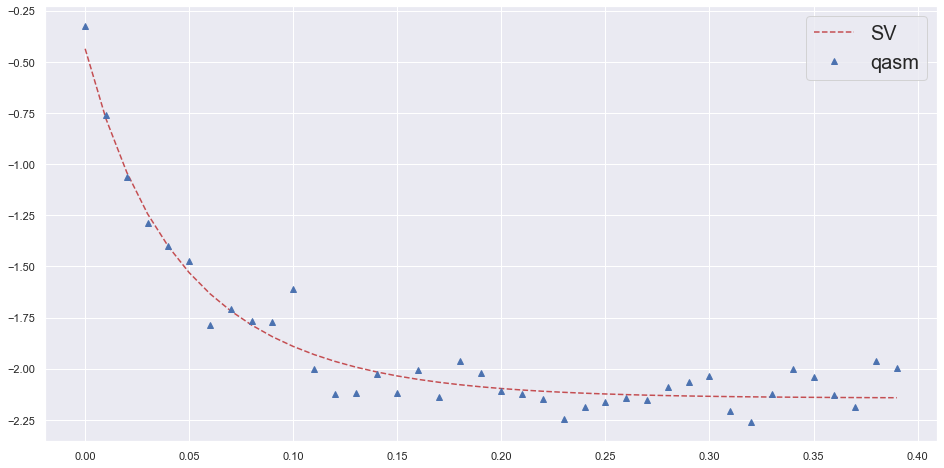

In [41]:
time=[delta_time*t for t in range(num_iterations)]
plt.plot(time,sv_energies,'r--',label="SV")
plt.plot(time,qasm_energies,'b^',label="qasm")
plt.legend(prop={'size': 20})

In [6]:
print(Ccoefs_sv)

[1.00436581 1.00778944 1.0104042  1.01243448 1.01403395 1.01531032
 1.0163404  1.01717986 1.01786962 1.01844022]


In [7]:
print(Ccoefs_qasm)

[1.00378783 1.00705574 1.01039165 1.01198037 1.01386246 1.01452111
 1.01638496 1.01545054 1.01865951 1.02070174]


In [139]:
## Construct overlap matrix
step=int(num_iterations/(2**n_qubits))
print(step)
coefs=[Ccoefs_sv[i] for i in range(0,len(Ccoefs_sv),step)]
energies=[sv_energies[i] for i in range(0,len(Ccoefs_sv),step)]
dim=len(coefs)
print(dim)
Omatrix=np.asmatrix(np.zeros((dim,dim)))
Hmatrix=np.asmatrix(np.zeros((dim,dim)))
for i in range(0,dim):
    for j in range(0,dim):
#         print(i,j)
        k=int((i+j)/2)
        Omatrix[i,j]=coefs[i]*coefs[j]/(coefs[k]**2)
# print(Omatrix)
## Construct H matrix 
for i in range(0,dim):
    for j in range(0,dim):
        k=int((i+j)/2)
        Hmatrix[i,j]=energies[k]
# print(Hmatrix)

eigs,vecs=eig(Hmatrix,Omatrix)
idx = eigs.real.argsort()[0]
print(idx)
# eigenValues = eigenValues[idx]
print(eigs.real)
print(sv_energies[-1])

6
9
0
[-2.21621009 47.93260936 47.93260936 50.50996863 50.50996863 51.26173034
 51.13206115 51.1223461  51.11231701]
-2.2090826141605895


In [ ]:
TODO: Remove T assumption on calculation of C n